## **Models Comparing on the same Dataset - Machine Learning**

# **Import libraries**

In [ ]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import time
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import ShuffleSplit,cross_val_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')


# **Load the data**

In [ ]:
df = pd.read_csv('/content/ex4_data.csv')

In [ ]:
df

,INTENSIVE,NEWSITEID,RISK10YRS,INCLUSIONFRS,SBP,DBP,N_AGENTS,NOAGENTS,SMOKE_3CAT,ASPIRIN,EGFR,SCREAT,SUB_CKD,RACE_BLACK,AGE,FEMALE,SUB_CVD,SUB_CLINICALCVD,SUB_SUBCLINICALCVD,SUB_SENIOR,RACE4,CHR,GLUR,HDL,TRR,UMALCR,BMI,STATIN,SBPTERTILE,EVENT_PRIMARY
0,Regular,74.0,29.732061,True,145,80,2,False,3,True,67.69,1.11,False,False,60,False,True,True,False,False,WHITE,155,81,36,92,5.80,33.115201,True,3,False
1,Regular,8.0,29.677619,True,138,71,1,False,2,True,60.64,1.17,False,False,75,False,False,False,False,True,WHITE,243,107,61,188,5.45,28.842380,True,2,False
2,Intensive,25.0,17.443819,True,143,92,2,False,2,False,68.44,1.09,False,False,62,False,False,False,False,False,WHITE,180,116,47,125,13.33,33.643060,False,2,False
3,Regular,96.0,8.627849,False,123,68,2,False,1,False,71.94,0.78,False,False,75,True,False,False,False,True,WHITE,234,93,89,109,6.12,29.337871,False,1,False
4,Intensive,42.0,23.751437,True,126,51,2,False,2,False,50.19,1.36,True,False,81,False,False,False,False,True,WHITE,126,108,39,84,28.78,36.660286,False,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8741,Regular,102.0,10.896486,False,138,59,2,False,2,True,79.57,0.71,False,False,78,True,False,False,False,True,WHITE,199,90,85,74,12.73,27.186534,True,2,False
8742,Regular,98.0,8.646088,False,119,73,3,False,2,False,22.60,2.08,True,False,85,True,False,False,False,True,WHITE,145,83,52,95,440.38,42.191997,True,1,False
8743,Regular,99.0,24.191491,True,137,75,0,True,2,False,74.74,1.00,False,False,66,False,True,True,False,False,WHITE,167,80,46,75,26.92,19.462021,True,2,False
8744,Intensive,15.0,20.354619,True,154,93,0,True,2,True,32.32,1.64,True,False,56,True,False,False,False,False,WHITE,245,103,37,369,3.20,35.579436,False,3,False


# **Cleaning and Transforming the data**

First, let's observe the distribution of the labels in the data.

In [ ]:
# Check if the data is balanced
df["EVENT_PRIMARY"].value_counts()

False    8207
True      539
Name: EVENT_PRIMARY, dtype: int64

Now, we need to replace the categorical values with numerical values.

In [ ]:
# Replace False by 0 and True by 1
df.replace({False: 0, True: 1}, inplace=True)

And check what are the possible values for the rest of the categorical columns, Replace those values with numerical values.

In [ ]:
print("Intensive column values:",set(df["INTENSIVE"].values))
print("Race4 column values:",set(df["RACE4"].values))


Intensive column values: {'Regular', 'Intensive'}
Race4 column values: {'OTHER', 'WHITE', 'HISPANIC', 'BLACK'}


In [ ]:
df.replace({'Intensive': 0, 'Regular': 1}, inplace=True)
df.replace({'BLACK': 0, 'HISPANIC': 1,'OTHER':2,'WHITE':3}, inplace=True)

Extract X - all the columns except 'EVENT_PRIMARY'(labels) and 'NEWSITEID' (identifier).

Extract y - the label column.

In [ ]:
y = df['EVENT_PRIMARY']


In [ ]:
X = df.drop(columns=['EVENT_PRIMARY','NEWSITEID'])

Check that there are no null values in the data.

In [ ]:
X.isnull().sum()

INTENSIVE             0
RISK10YRS             0
INCLUSIONFRS          0
SBP                   0
DBP                   0
N_AGENTS              0
NOAGENTS              0
SMOKE_3CAT            0
ASPIRIN               0
EGFR                  0
SCREAT                0
SUB_CKD               0
RACE_BLACK            0
AGE                   0
FEMALE                0
SUB_CVD               0
SUB_CLINICALCVD       0
SUB_SUBCLINICALCVD    0
SUB_SENIOR            0
RACE4                 0
CHR                   0
GLUR                  0
HDL                   0
TRR                   0
UMALCR                0
BMI                   0
STATIN                0
SBPTERTILE            0
dtype: int64

**Now, We can split the data into train and test, and create scaler object**

In [ ]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Standardize the data to have a mean of ~0 and a variance of 1
scaler = StandardScaler()
final_dict = {}

# **First model - Logistic Regression**

Create the Logistic Regression model, create the pipeline and fit the

In [ ]:
lr = LogisticRegression(random_state=0)
# create pipeline with the scaler, SMOTE and the logistic regression model
pipeline_lr = Pipeline(steps=[("scaler",scaler),('sampling', SMOTE()),("logisticReg",lr)])

grid={"logisticReg__C":[10**val for val in np.arange(-5, 5, dtype=float)],
      "logisticReg__penalty":["none","l2"],
      "logisticReg__max_iter": [1000, 2000, 5000, 10000]}

# create the cross validation object
lr_cv=GridSearchCV(pipeline_lr,grid,scoring='accuracy',cv=3)
lr_cv.fit(X_train,y_train)

# choosing the best estimator
lr_model=lr_cv.best_estimator_
print("Best parameters for the model: ",lr_cv.best_params_)

Best parameters for the model:  {'logisticReg__C': 0.001, 'logisticReg__max_iter': 1000, 'logisticReg__penalty': 'l2'}


In [ ]:
# fit the chosen model on the train data
start = time.time()
lr_model.fit(X_train, y_train)
fit = time.time()

Predict the X train to measure the performance of the model on the train data.

In [ ]:
final_dict['LR'] = {}
y_pred_lr = lr_model.predict(X_train)
# extract the confusion matrix measures
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_lr).ravel()
# extract mean accuracy from the cv
acc = np.mean(lr_cv.cv_results_['mean_test_score'])
specificity = tn/(tn+fp)
fit_time = fit-start
final_dict['LR']['fit_time'] = fit_time
print("Train result:")
print("True positive rate:", tp, "\nTrue negative rate:",tn, "\nFalse negative rate:",fn, "\nFalse positive rate:",fp,"\nAccuracy:",acc, "\nSpecificity:",
      specificity,"\nFit time:",fit_time)

Train result:
True positive rate: 257 
True negative rate: 4212 
False negative rate: 147 
False positive rate: 1943 
Accuracy: 0.673439700869021 
Specificity: 0.6843216896831844 
Fit time: 0.06823515892028809


Predict the X test for comaprison.

In [ ]:
# prediction on the test set
start_p = time.time()
y_pred_lr = lr_model.predict(X_test)
pred = time.time()
pred_time = pred-start_p
# extract the confusion matrix measures
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
acc = accuracy_score(y_test, y_pred_lr)
specificity = tn/(tn+fp)
final_dict['LR']['accuracy'] = acc
final_dict['LR']['specificity'] = specificity
final_dict['LR']['pred_time'] = pred_time
print("Test result:")
print("True positive rate:", tp, "\nTrue negative rate:",tn, "\nFalse negative rate:",fn, "\nFalse positive rate:",fp,"\nAccuracy:",acc, "\nSpecificity:",specificity,"\nPrediction time:",pred_time)

Test result:
True positive rate: 72 
True negative rate: 1415 
False negative rate: 63 
False positive rate: 637 
Accuracy: 0.6799268404206675 
Specificity: 0.6895711500974658 
Prediction time: 0.012643098831176758


**Check overfitting:**

In [ ]:
acc_lr_train = []
acc_lr_test = []
# for every c in range
for c in np.arange(-5, 5, dtype=float):
  # create logistic regression model with this c parameter
  lr = LogisticRegression(C=10**(c), random_state=0,max_iter=2000, penalty='l2')
  # create the pipeline
  pipeline_lr = Pipeline(steps=[("scaler",scaler),('sampling', SMOTE()),("logisticReg",lr)])
  pipeline_lr.fit(X_train, y_train)
  # extract the predicted labels for the train and test
  y_train_lr = pipeline_lr.predict(X_train)
  y_test_lr = pipeline_lr.predict(X_test)
  # calculate the accuracy for the train and the test and add to the lists
  acc_train = accuracy_score(y_train, y_train_lr)
  acc_test = accuracy_score(y_test, y_test_lr)
  acc_lr_train.append(acc_train)
  acc_lr_test.append(acc_test)

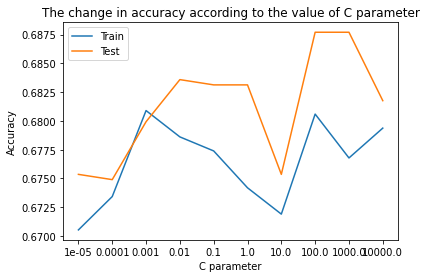

In [ ]:
# plot the graph
vals = [str(10**val) for val in np.arange(-5, 5, dtype=float)]
plt.plot(vals , acc_lr_train,label = "Train")
plt.plot(vals, acc_lr_test,label = "Test")
plt.legend()
plt.title("The change in accuracy according to the value of C parameter")
plt.xlabel('C parameter')
plt.ylabel('Accuracy')
plt.show()

### **Logistic Regression - Summary**
We chose to use logistic regression model because of the following reasons:
1. Logistic regression is valuable for predicting the likelihood of an event. It helps determine the probabilities between any two classes. We chose this model because we need to predict the primary event - whether the patient died or had a cardiovascular event.
2. Logistic regression makes no assumptions about distributions of classes in feature space.
3. Logistic regression model has good accuracy for smaller datasets as in our dataset - approximately 9000 samples (for both train and test).
**Configurations:**

* random_state - We chose to use a constant random parameter for all the models we compare.
* C - We use C parameter in order to check if the model is overfitting. For this parameter, if we choose small values, we increase the regularization strength which will create simple models which underfit the data.
* penalty - We chose this parameter in order to control the regularization of the model and avoid overfitting.
* max_iter - We chose to check what is the optimal number of iterations for this model, with this data. 

**Overfitting:**

As we can see in the graph, for small values of parameter C, the model tends to overfit, but from certain point, the model stopped to overfit, and the test results improves faster than the train result.

In addition to that, we used SMOTE, a method which supposed to do imbalance sampling. Because as we saw in the data exploration in the beginning of this notebook, the data is highly imbalanced.

**Final results:**
* Prediction time: 0.0156
* True positive rate: 72 
* True negative rate: 1401 
* False negative rate: 63 
* False positive rate: 651 
* **Accuracy: 0.6735253772290809**
* **Specificity: 0.6827485380116959**


# **Second model - Ensemble**

Create the Gradient Boosting Classifier model, create the pipeline and fit the

In [ ]:
clf = GradientBoostingClassifier(random_state=0)
# create pipeline with the scaler, SMOTE and the logistic regression model
pipeline_clf = Pipeline(steps=[("scaler",scaler),('sampling', SMOTE()),("GradientBoostingClassifier",clf)])

grid = {'GradientBoostingClassifier__max_depth': [1,3,5,10],
    'GradientBoostingClassifier__max_features': [None,3, 10, 20,28],
    'GradientBoostingClassifier__min_samples_leaf': [None,3, 4, 5],
    'GradientBoostingClassifier__min_samples_split': [None,8, 10, 12],
    'GradientBoostingClassifier__n_estimators': [10,15,30,50,100]
}      
# create the cross validation object
clf_cv=GridSearchCV(pipeline_clf,grid,scoring='accuracy',cv=3)
clf_cv.fit(X_train,y_train)

# choosing the best estimator
clf_model=clf_cv.best_estimator_
print("Best parameters for the model: ",clf_cv.best_params_)

Best parameters for the model:  {'GradientBoostingClassifier__max_depth': 10, 'GradientBoostingClassifier__max_features': 28, 'GradientBoostingClassifier__min_samples_leaf': 5, 'GradientBoostingClassifier__min_samples_split': 8, 'GradientBoostingClassifier__n_estimators': 100}


In [ ]:
# extracting the best parameters for the model, but using max_depth=1 , fit the chosen model on the train data
start = time.time()
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=1, random_state=0,min_samples_leaf= 4,min_samples_split=8)
pipeline_clf = Pipeline(steps=[("scaler",scaler),('sampling', SMOTE()),("GradientBoostingClassifier",gbc)])
pipeline_clf.fit(X_train, y_train)
fit = time.time()

Predict the X train to measure the performance of the model on the train data.

In [ ]:
final_dict['GB'] = {}
y_pred_clf = pipeline_clf.predict(X_train)
# extract the confusion matrix measures
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_clf).ravel()
# extract mean accuracy from the cv
acc = np.nanmean(clf_cv.cv_results_['mean_test_score'])
specificity = tn/(tn+fp)
fit_time = fit-start
final_dict['GB']['fit_time'] = fit_time
print("Train result:")
print("True positive rate:", tp, "\nTrue negative rate:",tn, "\nFalse negative rate:",fn, "\nFalse positive rate:",fp,"\nAccuracy:",acc, "\nSpecificity:",
      specificity,"\nFit time:",fit_time)

Train result:
True positive rate: 76 
True negative rate: 5854 
False negative rate: 328 
False positive rate: 301 
Accuracy: 0.8458717845431672 
Specificity: 0.9510966693744923 
Fit time: 2.2751364707946777


Predict the X test for comaprison.

In [ ]:
# prediction on the test set
start_p = time.time()
y_pred_clf = pipeline_clf.predict(X_test)
pred = time.time()
pred_time = pred-start_p
# extract the confusion matrix measures
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_clf).ravel()
acc = accuracy_score(y_test, y_pred_clf)
specificity = tn/(tn+fp)
final_dict['GB']['accuracy'] = acc
final_dict['GB']['specificity'] = specificity
final_dict['GB']['pred_time'] = pred_time

print("Test result:")
print("True positive rate:", tp, "\nTrue negative rate:",tn, "\nFalse negative rate:",fn, "\nFalse positive rate:",fp,"\nAccuracy:",acc, "\nSpecificity:",specificity,
      "\nPrediction time:",pred_time)

Test result:
True positive rate: 13 
True negative rate: 1945 
False negative rate: 122 
False positive rate: 107 
Accuracy: 0.8952903520804756 
Specificity: 0.9478557504873294 
Prediction time: 0.009197711944580078


**Check overfitting:**

In [ ]:
acc_clf_train = []
acc_clf_test = []
# for each number of estimators
est = [5,10,15,20,50,100,200,400,1000]
for n in est:
  # create gradient boosting classifier with the current number of estimators
  gbc = GradientBoostingClassifier(n_estimators=n, learning_rate=0.5, max_depth=1, random_state=0,min_samples_leaf= 4,min_samples_split=8)
  pipeline_clf = Pipeline(steps=[("scaler",scaler),('sampling', SMOTE()),("GradientBoostingClassifier",gbc)])
  pipeline_clf.fit(X_train, y_train)
  # extract the predicted labels for the train and test
  y_train_clf = pipeline_clf.predict(X_train)
  y_test_clf = pipeline_clf.predict(X_test)
  # calculate the accuracy for the train and the test and add to the lists
  acc_train = accuracy_score(y_train, y_train_clf)
  acc_test = accuracy_score(y_test, y_test_clf)
  acc_clf_train.append(acc_train)
  acc_clf_test.append(acc_test)

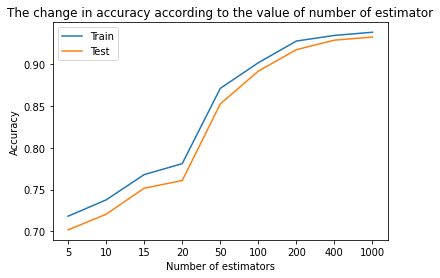

In [ ]:
# plot the graph
vals = [str(val) for val in est]
plt.plot(vals , acc_clf_train,label = "Train")
plt.plot(vals, acc_clf_test,label = "Test")
plt.legend()
plt.title("The change in accuracy according to the value of number of estimator")
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.show()

### **Gradient Boosting Classifier - Summary**
We chose to use Gradient Boosting Classifier because of the following reasons:
1. Gradient Boosting performs well when you have unbalanced data such as in real time risk assessment. We can see that the data is unbalanced as we presented in "Cleaning and Transforming the data" section.
2. Usually provides high accuracy.
3. Has better results than Random Forest and AdaBoost.

**Configurations:**

* random_state - We chose to use constant random parameter for all the models we compare.
* n_estimators - We chose low number of estimators in order to avoid overfitting (Although the model supposed to be robust to over-fitting).
* learning_rate - We wanted to choose a value of alpha that is not too slow, which will cause a slow learning process, however, we didn't want alpha to be too big as well. This is the reason we decided to use 0.5 as the value of alpha.
* max_depth - In order to avoid overfitting, we chose that each tree will be in max depth of 1. Which means that every tree in the ensemble will be in depth of 1.

**Overfitting:**

As we can see in the graph, the accuracy of the train predictions is always higher than the accuracy of the test predictions, but the gap is not significant.
Although in the cross validation, the best parameters for the max_depth, we will keep max_depth=1 because we want to avoid this overfitting.


In addition to that we used (again) the SMOTE method which helps us creating models for imbalanced data. 

**Final results:**

* Prediction time: 0.0067
* True positive rate: 14
* True negative rate: 1941 
* False negative rate: 121 
* False positive rate: 111 
* **Accuracy: 0.8939186099679927**
* **Specificity: 0.945906432748538**


# **Third model - Deep Learning**

Create the Multilayer Perceptron model, create the pipeline and fit the

In [ ]:
mlp = MLPClassifier(random_state=0,solver='adam',hidden_layer_sizes=(20, ))
# create pipeline with the scaler and the MLPClassifier model
pipeline_mlp = Pipeline(steps=[("scaler",scaler),('sampling', SMOTE()),("MLPClassifier",mlp)])


grid = {'MLPClassifier__batch_size':[100,200,300,400,600,800,1000],
        'MLPClassifier__max_iter': [500,1000,1500],
        'MLPClassifier__alpha': 10.0 ** -np.arange(1, 7)}

mlp_cv=GridSearchCV(pipeline_mlp,grid,scoring='accuracy',cv=3)
mlp_cv.fit(X_train,y_train)

# choosing the best estimator
mlp_model=mlp_cv.best_estimator_
print("Best parameters for the model: ",mlp_cv.best_params_)

Best parameters for the model:  {'MLPClassifier__alpha': 0.001, 'MLPClassifier__batch_size': 300, 'MLPClassifier__max_iter': 1500}


In [ ]:
# fit the chosen model on the train data
start = time.time()
mlp_model.fit(X_train, y_train)
fit = time.time()
fit_time = fit-start

Predict the X train to measure the performance of the model on the train data.

In [ ]:
final_dict['MLP'] = {}
y_pred_mlp = mlp_model.predict(X_train)
# extract the confusion matrix measures
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_mlp).ravel()
# extract mean accuracy from the cv
acc = acc = np.mean(mlp_cv.cv_results_['mean_test_score'])
specificity = tn/(tn+fp)
final_dict['MLP']['fit_time'] = fit_time
print("Train results:")
print("True positive rate:", tp, "\nTrue negative rate:",tn, "\nFalse negative rate:",fn, "\nFalse positive rate:",fp,"\nAccuracy:",acc, "\nSpecificity:",
      specificity,"\nFit time:",fit_time)

Train results:
True positive rate: 317 
True negative rate: 5379 
False negative rate: 87 
False positive rate: 776 
Accuracy: 0.8206133143979087 
Specificity: 0.873923639317628 
Fit time: 13.491843938827515


Predict the X test for comaprison.

In [ ]:
# prediction on the test set
start_p = time.time()
y_pred_mlp = mlp_model.predict(X_test)
pred = time.time()
# extract the confusion matrix measures
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mlp).ravel()
acc = accuracy_score(y_test, y_pred_mlp)
specificity = tn/(tn+fp)
pred_time = pred-start_p
final_dict['MLP']['accuracy'] = acc
final_dict['MLP']['specificity'] = specificity
final_dict['MLP']['pred_time'] = pred_time
print("Test results:")
print("True positive rate:", tp, "\nTrue negative rate:",tn, "\nFalse negative rate:",fn, "\nFalse positive rate:",fp,"\nAccuracy:",acc, "\nSpecificity:",specificity,
      "\nPrediction time:",pred_time)

Test results:
True positive rate: 36 
True negative rate: 1698 
False negative rate: 99 
False positive rate: 354 
Accuracy: 0.7928669410150891 
Specificity: 0.827485380116959 
Prediction time: 0.009119987487792969


**Check overfitting**

In [ ]:
acc_nn_train = []
acc_nn_test = []
time_nn_fit=[]
est = [50,100,200,300,400,600,800,1000,2000,10000]
for b in est:
  # create multilayer perceptron model with the changing batch size
  mlp = MLPClassifier(solver='adam', alpha=0.00001,hidden_layer_sizes=(20, ),max_iter=1000, random_state=0,batch_size=b)
  pipeline_nn = Pipeline(steps=[("scaler",scaler),('sampling', SMOTE()),("MLPClassifier",mlp)])
  start_p = time.time()
  pipeline_nn.fit(X_train, y_train)
  end_p = time.time()
  # extract the predicted labels for the train and test
  y_train_nn = pipeline_nn.predict(X_train)
  y_test_nn = pipeline_nn.predict(X_test)
  # calculate the accuracy for the train and the test and add to the lists
  acc_train = accuracy_score(y_train, y_train_nn)
  acc_test = accuracy_score(y_test, y_test_nn)
  acc_nn_train.append(acc_train)
  acc_nn_test.append(acc_test)
  time_nn_fit.append(end_p-start_p)

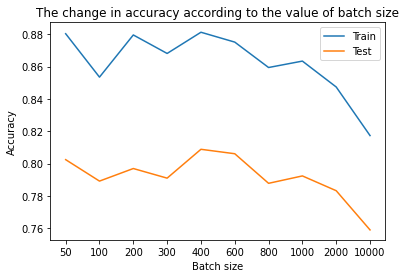

In [ ]:
# plot first graph - change in accuracy
vals = [str(val) for val in est]
plt.plot(vals , acc_nn_train,label = "Train")
plt.plot(vals, acc_nn_test,label = "Test")
plt.legend()
plt.title("The change in accuracy according to the value of batch size")
plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.show()


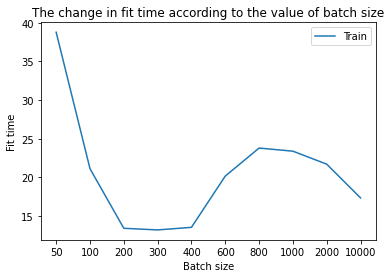

In [ ]:
# plot second graph - change in fit time
vals = [str(val) for val in est]
plt.plot(vals , time_nn_fit,label = "Train")
plt.legend()
plt.title("The change in fit time according to the value of batch size")
plt.xlabel('Batch size')
plt.ylabel('Fit time')
plt.show()


### **Deep Learning - Summary**
We chose to use Multilayer Perceptron because of the following reasons:
1. The model can learn nonlinear functions and thus separate not linearly separable data.
2. It provides quick predictions after training.

**Configurations:**

* random_state - We chose to use constant random parameter for all the models we compare.
* solver - We chose 'adam' optimizer, because this is the only solver that converged over our data, but in addition to that, we learned in class that this is the best optimizer in most cases.
* alpha - We chose small alpha in order to avoid overfitting, alpha represent the L2 penalty, which effects the coefficients of the model.
* hidden_layer_sizes - The first element represent the number of neurons in first hidden layer, and second element represent the number of neurons in the second hidden layer. Thus we have 2 hidden layers with different number of nodes in each layer. In the first layer we chose 2/3 the size of the input layer, plus the size of the output layer.
* batch_size - We see that for 200 the batch_size leads to the best accuracy, this effects the way the model learns the training data. 

**Overfitting:**

The model overfit for all the batch size chosen, but we can also see that as the batch size increases the gap between the train and the test decreases. The model is still over fit, but we can conclude that the batch size have an effect on the results of this model.


**Batch Size:**
- **In general**: As we increase the batch size, the model will decrease the generalization error, although too large of a batch size will lead to poor generalization. 
Using small batch sizes, might cause faster convergence, but it will converge to a local optima. If we will use batch size that equal to the size of the dataset, we will converge to the global optima, but slower. 
- **In this task**: As we can see in the first graph, as we increase the batch size, the gap between the accuracy of the train and test slightly shrinks, this could indicate that the generalization error decreases. Also, it seems that since batch_size=200, the train and the test accuracy scores trend lines behavior is similar. Another interesting thing we can see in the second graph is that the fitting time is changing according to the change in batch size, but the trend is not stable.

**Final results:**

* Prediction time: 0.009119987487792969
* True positive rate: 36
* True negative rate: 1698  
* False negative rate: 99
* False positive rate: 354  
* **Accuracy: 0.7928669410150891**
* **Specificity: 0.827485380116959**
 




#**Comapring the 3 models**

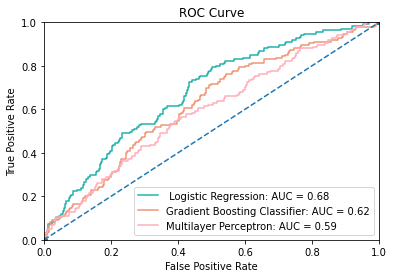

In [ ]:
# calculate roc curve for logistic regression model
probs_lr = lr_model.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, thresh = roc_curve(y_test, probs_lr)
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)
# calculate roc curve for gradient boosting classifier model
probs_gb = clf_model.predict_proba(X_test)[:,1]
fpr_gb, tpr_gb, thresh = roc_curve(y_test, probs_gb)
roc_auc_gb = metrics.auc(fpr_gb, tpr_gb)
# calculate roc curve for multilayer perceptron model
probs_mlp = mlp_model.predict_proba(X_test)[:,1]
fpr_mlp, tpr_mlp, thresh = metrics.roc_curve(y_test, probs_mlp)
roc_auc_mlp = metrics.auc(fpr_mlp, tpr_mlp)

# Plot the graph
plt.title('ROC Curve')
plt.plot(fpr_lr, tpr_lr, 'b', label = ' Logistic Regression: AUC = ' + str(round(roc_auc_lr,2)), color='#20B2AA')
plt.plot(fpr_gb, tpr_gb, 'b', label = 'Gradient Boosting Classifier: AUC = ' + str(round(roc_auc_gb,2)), color ='#EE9572')
plt.plot(fpr_mlp, tpr_mlp, 'b', label = 'Multilayer Perceptron: AUC = ' + str(round(roc_auc_mlp,2)), color ='#FFAEB9')
plt.plot([0, 1], [0, 1],'p--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [ ]:
for key in final_dict:
  print("Model:",key)
  print("---------------")
  print("Accuracy:",final_dict[key]['accuracy'])
  print("Specificity:",final_dict[key]['specificity'])
  print("Fit time:",final_dict[key]['fit_time'])
  print("Predict time:",final_dict[key]['pred_time'])
  print("---------------------------------")

Model: LR
---------------
Accuracy: 0.6799268404206675
Specificity: 0.6895711500974658
Fit time: 0.06823515892028809
Predict time: 0.012643098831176758
---------------------------------
Model: GB
---------------
Accuracy: 0.8952903520804756
Specificity: 0.9478557504873294
Fit time: 2.2751364707946777
Predict time: 0.009197711944580078
---------------------------------
Model: MLP
---------------
Accuracy: 0.7928669410150891
Specificity: 0.827485380116959
Fit time: 13.491843938827515
Predict time: 0.009119987487792969
---------------------------------


# **Final Summary**
- We can see that for all the models that we have checked, the result that we received were high , both in the accuracy and in the specificity. But all of the models had also a tendency to overfit. In order to compare between them we decided to look on the parameters we explored for each model seperatly like Accuracy and Overfit, but also compare them in new parameters like ROC curve.
- When we look of the overfitting of all the models:

    a. We can see that the Logistic Regression overfits only for lower values of the C parameter , the accuracy of this model is the lowest, but the AUC value for this model is the highest, which can indicates good performance on future data.

    b.We can see for the Gardient Boosting model that it is not overfitting throughout almost all of the numbers of estimators we have checked and we can consider using this model for our data.

    c. We can see that for the Multilayer Perceptron model, for lower values of batch sizes the model tends to overfit, but in general, for all batch sizes, we saw that the model overfit the training data.

- In order to decide which model is better for our data set we decided to look at the ROC curve & AUC parameters for each model. As we learned in class the best model is the one with the highest AUC score because it means its preformances are the best for this data set. We can see that for most values, the logistic regression model, has better performace than the other 2 models. 

- As we learned in class, there is a principal called "No free lunch". The theorem states that all optimization algorithms perform equally well when their performance is averaged across all possible problems. We can see that there is difference between the accuracy results for these 3 models, and from accuracy prespective, we probably would have chosen the Gradient Boosting model. But the accuracy is not our only measurement of choosing the right model. So if we must choose one model we decided to choose Logistic Regression because of its ROC curve. As it seems from the graph the LR preformes better than the other 2 models through almost all of the areas of its AUC.In addition, as we can see the LR model also has the fastest fitting time.